In [ ]:
# Cell: Import thư viện
!pip install pandas numpy scikit-learn gensim pyLDAvis wordcloud matplotlib seaborn python-Levenshtein sentence-transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Vectorization (Embedding)
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.preprocessing import MinMaxScaler # Dùng để chuẩn hoá cho LSA nếu cần
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer # Thêm dòng này để import TfidfVectorizer

# Topic Modeling & Clustering
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering # Added AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer # Vẫn cần cho LDA

# Visualization
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

# Metrics
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
import Levenshtein

# Constants
INPUT_CSV = r"/content/final_data.csv"
N_TOPICS = 15
N_TOP_WORDS = 15  # Số từ đại diện cho mỗi topic
EMBEDDING_DIM = 100 # Định nghĩa kích thước embedding cho Doc2Vec
RANDOM_STATE = 42

In [4]:
df = pd.read_csv(INPUT_CSV)
print(f"✓ Đã load {len(df)} documents")
print(f"✓ Các cột: {list(df.columns)}")

✓ Đã load 2389 documents
✓ Các cột: ['description', 'category']


In [5]:
print(f"\nThống kê category:")
print(df['category'].value_counts())


Thống kê category:
category
Tin mới         1657
Xe               249
Thế giới          86
Pháp luật         80
Thời sự           72
Giải trí          59
Thể thao          51
Kinh doanh        35
Xã hội            24
Bóng đá           16
Giáo dục          13
Sức khỏe          10
Công nghệ          8
Chính trị          6
Du lịch            5
Văn hóa            5
Bất động sản       4
Đời sống           4
Số hóa             3
Khoa học           2
Name: count, dtype: int64


In [6]:
documents = df['description'].tolist()
print(f"\n✓ Sẽ dùng {len(documents)} documents cho topic modeling")

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    max_features=5000,      # Giới hạn 5000 từ
    min_df=5,               # Từ phải xuất hiện ít nhất 5 documents
    max_df=0.7,             # Từ không xuất hiện quá 70% documents
    ngram_range=(1, 2)      # Unigram và bigram
)
doc_term_matrix = vectorizer.fit_transform(documents)
count_feature_names = vectorizer.get_feature_names_out()

print(f"\n✓ Document-Term Matrix shape: {doc_term_matrix.shape}")
print(f"  - Số documents: {doc_term_matrix.shape[0]}")
print(f"  - Số features (từ): {doc_term_matrix.shape[1]}")
print(f"  - Sparsity: {(1 - doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1])) * 100:.2f}%")

print(f"\n ✓ Sẽ dùng matrix này cho CẢ 4 models: LDA, LSA, K-Means, HAC")

# Lấy tokenized documents cho Doc2Vec/embedding models
tokenized_documents = [doc.lower().split() for doc in documents]

# Lấy feature names
print(f"\n Ví dụ features: {list(count_feature_names[:20])}")


✓ Sẽ dùng 2389 documents cho topic modeling

✓ Document-Term Matrix shape: (2389, 5000)
  - Số documents: 2389
  - Số features (từ): 5000
  - Sparsity: 98.19%

 ✓ Sẽ dùng matrix này cho CẢ 4 models: LDA, LSA, K-Means, HAC

 Ví dụ features: ['a_bank', 'air', 'album', 'an_giang', 'an_khánh', 'an_ninh', 'an_ninh mạng', 'an_ninh quốc_gia', 'an_ninh trật_tự', 'an_ninh điều_tra', 'an_ninh_mạng', 'an_ninh_mạng phòng_chống', 'an_ninh_mạng quốc_gia', 'an_sinh', 'an_sinh xã_hội', 'an_toàn', 'an_toàn chạy_tàu', 'an_toàn công_trình', 'an_toàn giao_thông', 'an_toàn thực_phẩm']


In [7]:
print("\nTraining Doc2Vec model...")
tagged_data = [TaggedDocument(words=tokens, tags=[str(i)])
               for i, tokens in enumerate(tokenized_documents)]

doc2vec_model = Doc2Vec(
    vector_size=EMBEDDING_DIM,
    min_count=5,
    epochs=40,
    window=5,
    workers=4
)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

d2v_embeddings = np.array([doc2vec_model.infer_vector(doc.words) for doc in tagged_data])
print(f"✓ Doc2Vec embeddings shape: {d2v_embeddings.shape}")


Training Doc2Vec model...
✓ Doc2Vec embeddings shape: (2389, 100)


In [8]:
print("\nTraining TF-IDF Vectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2)
)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"✓ TF-IDF matrix shape: {tfidf_matrix.shape}")


Training TF-IDF Vectorizer...
✓ TF-IDF matrix shape: (2389, 5000)


In [9]:
import numpy as np

# Chuẩn hóa Doc2Vec embeddings
d2v_embeddings = d2v_embeddings / (np.linalg.norm(d2v_embeddings, axis=1, keepdims=True) + 1e-8)
print(f"Normalized Doc2Vec embeddings")

# Initialize st_embeddings to None
st_embeddings = None

# Chuẩn hóa SentenceTransformer nếu có
if st_embeddings is not None:
    st_embeddings = st_embeddings / (np.linalg.norm(st_embeddings, axis=1, keepdims=True) + 1e-8)
    print(f"Normalized SentenceTransformer embeddings")

Normalized Doc2Vec embeddings


In [11]:
models = {}
doc_topic_distributions = {}

In [12]:
print("\n[3] Training LDA Model...")
lda_model = LatentDirichletAllocation(
    n_components=N_TOPICS,
    max_iter=50,
    learning_method='online',
    random_state=RANDOM_STATE,
    batch_size=128,
    n_jobs=-1,
    verbose=0,
)
lda_output = lda_model.fit_transform(doc_term_matrix)
models['LDA'] = lda_model
doc_topic_distributions['LDA'] = lda_output

print(f"LDA trained - Perplexity: {lda_model.perplexity(doc_term_matrix):.2f}")


[3] Training LDA Model...
LDA trained - Perplexity: 825.16


In [13]:
print("\n[3.2] Training LSA Model...")
lsa_model = TruncatedSVD(
    n_components=N_TOPICS,
    algorithm='randomized',
    n_iter=100,
    random_state=RANDOM_STATE,
)
lsa_output = lsa_model.fit_transform(doc_term_matrix)
models['LSA'] = lsa_model
doc_topic_distributions['LSA'] = lsa_output

# Normalize LSA output to get pseudo-probabilities
lsa_output_normalized = np.abs(lsa_output)
lsa_output_normalized = lsa_output_normalized / lsa_output_normalized.sum(axis=1, keepdims=True)
doc_topic_distributions['LSA'] = lsa_output_normalized

explained_var = lsa_model.explained_variance_ratio_.sum()
print(f"✓ LSA trained - Explained variance: {explained_var*100:.2f}%")


[3.2] Training LSA Model...
✓ LSA trained - Explained variance: 34.51%


In [14]:
print("\n[3.3] Training K-Means Model...")
# Sử dụng Doc2Vec embeddings
embeddings_for_kmeans = d2v_embeddings

kmeans_model = KMeans(
    n_clusters=N_TOPICS,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=RANDOM_STATE
)
kmeans_labels = kmeans_model.fit_predict(embeddings_for_kmeans)
models['KMeans'] = kmeans_model

# Tạo pseudo document-topic distribution từ distances
kmeans_distances = kmeans_model.transform(embeddings_for_kmeans)
# Convert distances thành probabilities (inverse distance)
kmeans_probs = 1 / (1 + kmeans_distances)
kmeans_probs = kmeans_probs / kmeans_probs.sum(axis=1, keepdims=True)
doc_topic_distributions['KMeans'] = kmeans_probs

print(f"✓ K-Means trained - Inertia: {kmeans_model.inertia_:.2f}")


[3.3] Training K-Means Model...
✓ K-Means trained - Inertia: 1412.02


In [15]:
print("\n[3.4] Training HAC Model...")
hac_model = AgglomerativeClustering(
    n_clusters=N_TOPICS,
    metric='cosine',
    linkage='average'
)
hac_labels = hac_model.fit_predict(doc_term_matrix.toarray())
models['HAC'] = hac_model

# Tạo pseudo distribution cho HAC (one-hot encoding)
hac_probs = np.zeros((len(hac_labels), N_TOPICS))
hac_probs[np.arange(len(hac_labels)), hac_labels] = 1
doc_topic_distributions['HAC'] = hac_probs

print(f"✓ HAC trained")


[3.4] Training HAC Model...
✓ HAC trained


In [16]:
print("\n" + "="*80)
print("BƯỚC 4: TOP WORDS CHO MỖI MODEL")
print("="*80)

def get_top_words_from_components(components, feature_names, n_top_words):
    """Lấy top words từ component matrix (LDA/LSA)"""
    topics_words = []
    for topic_idx, topic in enumerate(components):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

def get_top_words_from_labels(embeddings, labels, documents, n_clusters, n_top_words, tfidf_vec, tfidf_feat):
    """Lấy top words từ cluster docs bằng TF-IDF aggregation"""
    topics_words = []

    for cluster_id in range(n_clusters):
        cluster_docs = [documents[i] for i in range(len(documents)) if labels[i] == cluster_id]

        if cluster_docs:
            # Tính TF-IDF cho cluster
            cluster_text = ' '.join(cluster_docs)
            cluster_vec = tfidf_vec.transform([cluster_text])

            # Lấy top words
            top_indices = cluster_vec.toarray()[0].argsort()[-n_top_words:][::-1]
            top_words = [tfidf_feat[i] for i in top_indices if cluster_vec.toarray()[0][i] > 0]
            topics_words.append(top_words[:n_top_words])
        else:
            topics_words.append([])

    return topics_words


BƯỚC 4: TOP WORDS CHO MỖI MODEL


In [17]:
# Trích xuất top words
all_topics_words = {}

In [18]:
print("\n[4.1] LDA Top Words:")
all_topics_words['LDA'] = get_top_words_from_components(
    lda_model.components_, count_feature_names, N_TOP_WORDS,
)
for idx, words in enumerate(all_topics_words['LDA']):
    print(f"  Topic {idx}: {', '.join(words[:8])}")


[4.1] LDA Top Words:
  Topic 0: người_dân, địa_phương, ban_nhân_dân, quy_định, môi_trường, hộ, đất, tổ_chức
  Topic 1: dự_án, trung_ương, phát_triển, đại_biểu, quốc_hội, nghị_quyết, kinh_tế, thành_phố
  Topic 2: giao_thông, đường_sắt, an_toàn, tuyến, km, xây_dựng, phương_tiện, đoạn
  Topic 3: vietlott, giải, chủ_nhật, thưởng, huế, xspy, trúng, phú_yên
  Topic 4: giá, vàng, mua, cập_nhật, giá vàng, hãng, việt_nam, niêm_yết
  Topic 5: doanh_nghiệp, lũ, kỳ, sông, đăng_ký, vốn, hoạt_động, bão
  Topic 6: thị_trường, ngân_hàng, lãi_suất, kinh_tế, ổn_định, trung_ương, khả_năng, giao_dịch
  Topic 7: nuôi, tàu, đà_nẵng, biên_phòng, quốc_phòng, hải_quân, thành_phố, quan_hệ
  Topic 8: trận, việt_nam, nữ, philippines, đội, bóng, đấu, huấn_luyện_viên
  Topic 9: tin_tức, xuất_hành, hướng, hoàng_đạo, cầu, xấu, hắc_đạo, kỵ
  Topic 10: thành_phố, chí_minh, thành_phố chí_minh, tàu, vũng, vũng tàu, gia_đình, tphcm
  Topic 11: việt_nam, phát_triển, trường, tổ_chức, học_sinh, chương_trình, cộng_đồng, công

In [19]:
print("\n[4.2] LSA Top Words:")
all_topics_words['LSA'] = get_top_words_from_components(
    lsa_model.components_, count_feature_names, N_TOP_WORDS,
)
for idx, words in enumerate(all_topics_words['LSA']):
    print(f"  Topic {idx}: {', '.join(words[:8])}")


[4.2] LSA Top Words:
  Topic 0: mưa, nhiệt_độ, rét, dông, nhất_độ, nhiệt_độ nhất_độ, rải_rác, mưa_rào
  Topic 1: giá, trung_ương, vàng, dự_án, việt_nam, doanh_nghiệp, phát_triển, tổ_chức
  Topic 2: giá, vàng, giá vàng, mua, niêm_yết, phiên, giao_dịch, cập_nhật
  Topic 3: vietlott, giải, vietlott vietlott, power, thưởng, trúng, giải giải, vietlott power
  Topic 4: giải, giải giải, thưởng, trúng, giải trúng, trúng giải, trị_giá, vé
  Topic 5: doanh_nghiệp, đăng_ký, kỳ, vốn, thành_lập, vốn đăng_ký, hoạt_động, doanh_nghiệp thành_lập
  Topic 6: vàng, giá vàng, mua, trung_ương, phiên, dự_án, đồng_lượng, sjc
  Topic 7: giá, dự_án, đại_biểu, trung_ương, quốc_hội, cập_nhật, chi_tiết, viết
  Topic 8: ngân_hàng, thị_trường, lãi_suất, nhà_nước, kinh_tế, ngân_hàng nhà_nước, chính_sách, ổn_định
  Topic 9: việt_nam, trận, nữ, philippines, vàng, bóng, nữ việt_nam, đội_tuyển
  Topic 10: dự_án, trung_ương, việt_nam, trận, nữ, philippines, tuyến, nuôi
  Topic 11: đường_sắt, giao_thông, công_an, nhất_độ,

In [20]:
print("\n[4.3] K-Means Top Words:")
all_topics_words['KMeans'] = get_top_words_from_labels(
    embeddings_for_kmeans, kmeans_labels, documents, N_TOPICS, N_TOP_WORDS, tfidf_vectorizer, tfidf_feature_names
)
for idx, words in enumerate(all_topics_words['KMeans']):
    print(f"  Topic {idx}: {', '.join(words[:8])}")


[4.3] K-Means Top Words:
  Topic 0: trận, philippines, nữ, bóng, việt_nam, đấu, đội, huấn_luyện_viên
  Topic 1: phim, khán_giả, việt_nam, hạnh_phúc, thi, nhân_tạo, sống, diễn_viên
  Topic 2: nuôi, trường, dự_án, việt_nam, phát_triển, học_sinh, hoạt_động, chương_trình
  Topic 3: ukraine, tổng_thống, mỹ, nga, thái_lan, campuchia, châu_âu, trung_quốc
  Topic 4: giá, hãng, cập_nhật, dòng, viết, chi_tiết, mẫu, giá hãng
  Topic 5: mưa, nhiệt_độ, rét, dông, rải_rác, nhất_độ, mưa_rào, trời
  Topic 6: giá, vàng, giá vàng, ngân_hàng, mua, thị_trường, lãi_suất, phiên
  Topic 7: dự_án, đại_biểu, trung_ương, quốc_hội, cơ_chế, nghị_quyết, điện, phát_triển
  Topic 8: hà_nội, doanh_nghiệp, dự_án, thành_phố, không_khí, môi_trường, ô_nhiễm, trung_ương
  Topic 9: hội_đồng_nhân_dân, công_tác, nhiệm_vụ, đại_biểu, trung_ương, đảng, tổ_chức, ban
  Topic 10: vietlott, chủ_nhật, xspy, vietlott vietlott, huế, power, phú_yên, vietlott power
  Topic 11: giải, thưởng, giải giải, trúng, xuất_hành, vé, hoàng_đạo, h

In [21]:
print("\n[4.4] HAC Top Words:")
all_topics_words['HAC'] = get_top_words_from_labels(
    d2v_embeddings, hac_labels, documents, N_TOPICS, N_TOP_WORDS, tfidf_vectorizer, tfidf_feature_names
)
for idx, words in enumerate(all_topics_words['HAC']):
    print(f"  Topic {idx}: {', '.join(words[:8])}")


[4.4] HAC Top Words:
  Topic 0: dự_án, trung_ương, doanh_nghiệp, phát_triển, đại_biểu, quốc_hội, thành_phố, tổ_chức
  Topic 1: bé, chó, công_ty, tin_tức, bệnh_viện, bé gái, máu, gái
  Topic 2: công_an, giao_thông, đường_sắt, cảnh_sát, vi_phạm, đối_tượng, tiền, lực_lượng
  Topic 3: mưa, nhiệt_độ, rét, dông, biển, nhất_độ, trời, nhiệt_độ nhất_độ
  Topic 4: trận, philippines, việt_nam, nữ, bóng, huấn_luyện_viên, nữ việt_nam, đội_tuyển
  Topic 5: album, mùa, thu, phát_sóng, xuân, tạm dừng, cân_nhắc, phát_hành
  Topic 6: phim, khán_giả, diễn_viên, sống, hoa_hậu, cảm_xúc, ca_sĩ, âm_nhạc
  Topic 7: vietlott, giải, thưởng, chủ_nhật, xspy, vietlott vietlott, trúng, giải giải
  Topic 8: hoa, trà, rùa, núi, loài, gốc, dầu, tự_nhiên
  Topic 9: đậu, giàu, chuyên_gia, chất, nguy_cơ, tử_vong, thực_phẩm, thực_vật
  Topic 10: nga, tổng_thống, thái_lan, ukraine, campuchia, mỹ, biên_giới, israel
  Topic 11: xuất_hành, hoàng_đạo, hắc_đạo, kỵ, kiện_tụng, xấu, cầu, cưới_hỏi
  Topic 12: bay, hàng_không, hãn

In [22]:
def generate_topic_caption(top_words, top_n=3):
    """Sinh caption tự động"""
    caption_words = [w.replace('_', ' ') for w in top_words[:top_n]]
    return ' + '.join(caption_words).title()

all_captions = {}

for model_name, topics_words in all_topics_words.items():
    print(f"\n[5.{list(all_topics_words.keys()).index(model_name)+1}] {model_name} Captions:")
    captions = {}
    for idx, words in enumerate(topics_words):
        caption = generate_topic_caption(words, top_n=3) if words else f"Topic {idx}"
        captions[idx] = caption
        print(f"  Topic {idx}: {caption}")
    all_captions[model_name] = captions


[5.1] LDA Captions:
  Topic 0: Người Dân + Địa Phương + Ban Nhân Dân
  Topic 1: Dự Án + Trung Ương + Phát Triển
  Topic 2: Giao Thông + Đường Sắt + An Toàn
  Topic 3: Vietlott + Giải + Chủ Nhật
  Topic 4: Giá + Vàng + Mua
  Topic 5: Doanh Nghiệp + Lũ + Kỳ
  Topic 6: Thị Trường + Ngân Hàng + Lãi Suất
  Topic 7: Nuôi + Tàu + Đà Nẵng
  Topic 8: Trận + Việt Nam + Nữ
  Topic 9: Tin Tức + Xuất Hành + Hướng
  Topic 10: Thành Phố + Chí Minh + Thành Phố Chí Minh
  Topic 11: Việt Nam + Phát Triển + Trường
  Topic 12: Công An + Lực Lượng + Tiền
  Topic 13: Mưa + Nhiệt Độ + Rét
  Topic 14: Công Tác + Tổ Chức + Ban

[5.2] LSA Captions:
  Topic 0: Mưa + Nhiệt Độ + Rét
  Topic 1: Giá + Trung Ương + Vàng
  Topic 2: Giá + Vàng + Giá Vàng
  Topic 3: Vietlott + Giải + Vietlott Vietlott
  Topic 4: Giải + Giải Giải + Thưởng
  Topic 5: Doanh Nghiệp + Đăng Ký + Kỳ
  Topic 6: Vàng + Giá Vàng + Mua
  Topic 7: Giá + Dự Án + Đại Biểu
  Topic 8: Ngân Hàng + Thị Trường + Lãi Suất
  Topic 9: Việt Nam + Trận + Nữ
 

In [23]:
# LDA
df['topic_LDA'] = lda_output.argmax(axis=1)
df['topic_prob_LDA'] = lda_output.max(axis=1)

In [24]:
# LSA
df['topic_LSA'] = lsa_output_normalized.argmax(axis=1)
df['topic_prob_LSA'] = lsa_output_normalized.max(axis=1)

In [25]:
# K-Means
df['topic_KMeans'] = kmeans_labels
df['topic_prob_KMeans'] = kmeans_probs.max(axis=1)

In [26]:
# HAC
df['topic_HAC'] = hac_labels
df['topic_prob_HAC'] = 1.0  # HAC là hard clustering

In [27]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n{model_name} - Phân bố documents:")
    print(df[f'topic_{model_name}'].value_counts().sort_index())


LDA - Phân bố documents:
topic_LDA
0     176
1     233
2      99
3     228
4     254
5      70
6     292
7      37
8     107
9      69
10     70
11    277
12    201
13    151
14    125
Name: count, dtype: int64

LSA - Phân bố documents:
topic_LSA
0     159
1     895
2     120
3      78
4      69
5      49
6     110
7     113
8      70
9     137
10    130
11    124
12     63
13    119
14    153
Name: count, dtype: int64

KMeans - Phân bố documents:
topic_KMeans
0      84
1     133
2     167
3     111
4     129
5     176
6     177
7      87
8     170
9     157
10    408
11     92
12    189
13    104
14    205
Name: count, dtype: int64

HAC - Phân bố documents:
topic_HAC
0     723
1     121
2     270
3     274
4     159
5       4
6      46
7     230
8      15
9       1
10    108
11     27
12     19
13    357
14     35
Name: count, dtype: int64


In [28]:
def calculate_compactness_cosine(doc_vectors, labels):
    """Compactness - Cosine distance"""
    unique_labels = np.unique(labels)
    compactness_scores = []

    for label in unique_labels:
        cluster_docs = doc_vectors[labels == label]
        if len(cluster_docs) > 1:
            cos_dist = cosine_distances(cluster_docs)
            n = len(cluster_docs)
            avg_dist = (cos_dist.sum() - n) / (n * (n - 1))
            compactness_scores.append(avg_dist)

    return np.mean(compactness_scores)

def calculate_separation_cosine(doc_vectors, labels):
    """Separation - Cosine distance"""
    unique_labels = np.unique(labels)
    centroids = []

    for label in unique_labels:
        cluster_docs = doc_vectors[labels == label]
        centroid = cluster_docs.mean(axis=0)
        centroids.append(centroid)

    centroids = np.array(centroids)
    cos_dist = cosine_distances(centroids)
    n_clusters = len(unique_labels)
    avg_separation = (cos_dist.sum() - n_clusters) / (n_clusters * (n_clusters - 1))

    return avg_separation

In [29]:
# Tính metrics cho tất cả models
evaluation_results = []

In [30]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[7.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] Evaluating {model_name}...")

    doc_vectors = doc_topic_distributions[model_name]
    labels = df[f'topic_{model_name}'].values

    # Compactness
    compactness = calculate_compactness_cosine(doc_vectors, labels)

    # Separation
    separation = calculate_separation_cosine(doc_vectors, labels)

    # Silhouette Score
    silhouette = silhouette_score(doc_vectors, labels, metric='cosine')

    # Levenshtein
    captions = [all_captions[model_name][i] for i in range(N_TOPICS)]
    lev_distances = []
    for i in range(len(captions)):
        for j in range(i+1, len(captions)):
            lev_distances.append(Levenshtein.distance(captions[i], captions[j]))
    avg_lev = np.mean(lev_distances) if lev_distances else 0

    evaluation_results.append({
        'Model': model_name,
        'Compactness_Cosine': compactness,
        'Separation_Cosine': separation,
        'Silhouette_Cosine': silhouette,
        'Avg_Levenshtein': avg_lev
    })

    print(f"  ✓ Compactness: {compactness:.4f}")
    print(f"  ✓ Separation: {separation:.4f}")
    print(f"  ✓ Silhouette: {silhouette:.4f}")
    print(f"  ✓ Levenshtein: {avg_lev:.2f}")


[7.1] Evaluating LDA...
  ✓ Compactness: 0.1412
  ✓ Separation: 0.8424
  ✓ Silhouette: 0.7320
  ✓ Levenshtein: 22.77

[7.2] Evaluating LSA...
  ✓ Compactness: 0.0971
  ✓ Separation: 0.4145
  ✓ Silhouette: 0.2884
  ✓ Levenshtein: 21.05

[7.3] Evaluating KMeans...
  ✓ Compactness: -0.0071
  ✓ Separation: -0.0707
  ✓ Silhouette: 0.3158
  ✓ Levenshtein: 21.14

[7.4] Evaluating HAC...
  ✓ Compactness: -0.0422
  ✓ Separation: 0.9286
  ✓ Silhouette: 0.9996
  ✓ Levenshtein: 20.91


In [31]:
# Tạo DataFrame so sánh
eval_df = pd.DataFrame(evaluation_results)
print("\n" + "="*80)
print("📊 BẢNG SO SÁNH 4 MODELS:")
print("="*80)
print(eval_df.to_string(index=False))

# Lưu file
eval_df.to_csv('comparison_all_models_embedding.csv', index=False)
print("\n✓ Đã lưu: comparison_all_models_embedding.csv")


📊 BẢNG SO SÁNH 4 MODELS:
 Model  Compactness_Cosine  Separation_Cosine  Silhouette_Cosine  Avg_Levenshtein
   LDA            0.141200           0.842441           0.732023        22.771429
   LSA            0.097124           0.414453           0.288406        21.047619
KMeans           -0.007086          -0.070736           0.315845        21.142857
   HAC           -0.042169           0.928571           0.999581        20.914286

✓ Đã lưu: comparison_all_models_embedding.csv


In [32]:
def create_wordcloud_for_model(model_name, topics_words, n_topics):
    """Tạo WordCloud cho 1 model"""
    n_cols = 2
    n_rows = (n_topics + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_topics > 1 else [axes]

    for idx in range(n_topics):
        # Tạo word frequency dict
        words = topics_words[idx]
        if words:
            word_freq = {word: len(words) - i for i, word in enumerate(words)}
        else:
            word_freq = {f"topic_{idx}": 1}

        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            colormap='viridis',
            max_words=50
        ).generate_from_frequencies(word_freq)

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'Topic {idx}: {all_captions[model_name][idx]}',
                           fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    for idx in range(n_topics, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'{model_name} - WordClouds (Embedding)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'wordclouds_{model_name}_embedding.png', dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: wordclouds_{model_name}_embedding.png")
    plt.close()

In [33]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[8.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] Tạo WordCloud cho {model_name}...")
    create_wordcloud_for_model(model_name, all_topics_words[model_name], N_TOPICS)


[8.1] Tạo WordCloud cho LDA...
✓ Đã lưu: wordclouds_LDA_embedding.png

[8.2] Tạo WordCloud cho LSA...
✓ Đã lưu: wordclouds_LSA_embedding.png

[8.3] Tạo WordCloud cho KMeans...
✓ Đã lưu: wordclouds_KMeans_embedding.png

[8.4] Tạo WordCloud cho HAC...
✓ Đã lưu: wordclouds_HAC_embedding.png


In [34]:
print("Đang tạo pyLDAvis...")
vis_data = pyLDAvis.lda_model.prepare(
    lda_model,
    doc_term_matrix,
    vectorizer,
    mds='tsne',
    sort_topics=False,
)
pyLDAvis.save_html(vis_data, 'lda_visualization_embedding.html')
print("✓ Đã lưu: lda_visualization_embedding.html")

Đang tạo pyLDAvis...
✓ Đã lưu: lda_visualization_embedding.html


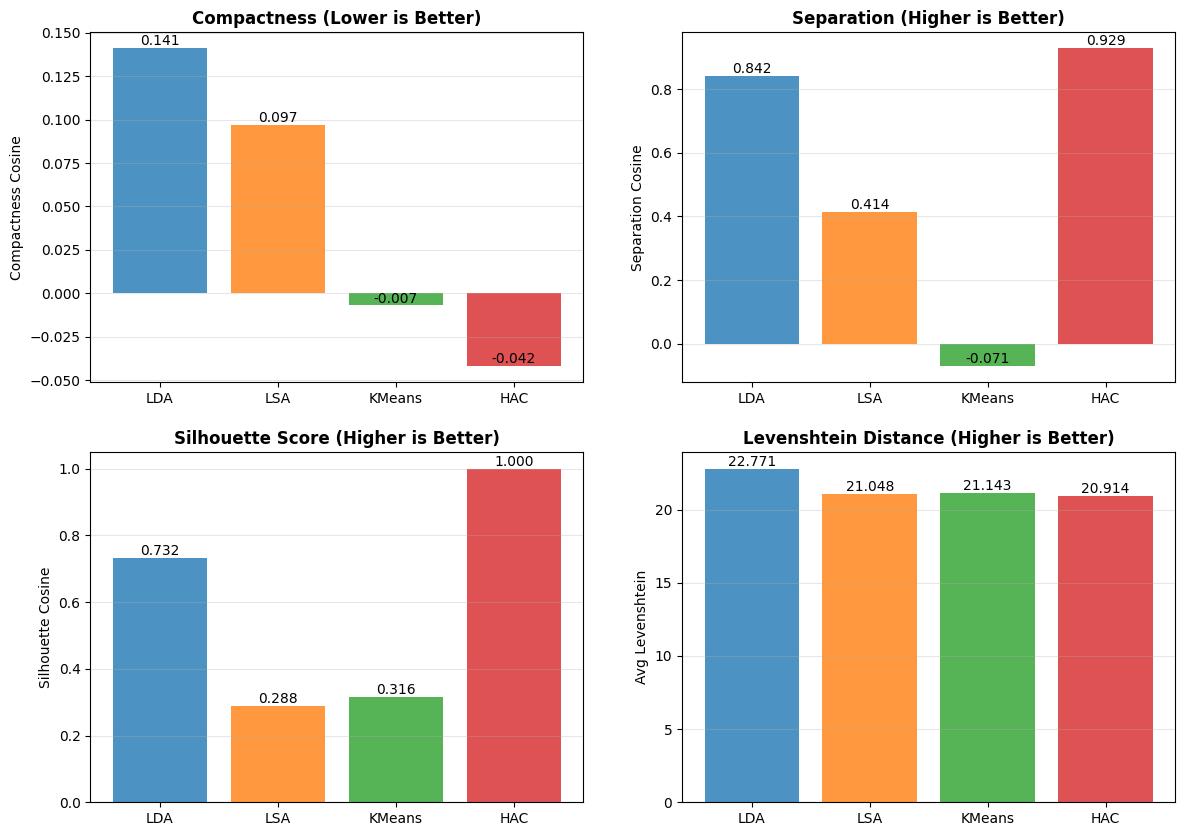

In [35]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Compactness_Cosine', 'Separation_Cosine', 'Silhouette_Cosine', 'Avg_Levenshtein']
titles = ['Compactness (Lower is Better)', 'Separation (Higher is Better)',
          'Silhouette Score (Higher is Better)', 'Levenshtein Distance (Higher is Better)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = ax.bar(eval_df['Model'], eval_df[metric], color=colors, alpha=0.8)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.replace('_', ' '))
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

In [36]:
plt.tight_layout()
plt.savefig('comparison_metrics_chart_embedding.png', dpi=300, bbox_inches='tight')
print("✓ Đã lưu: comparison_metrics_chart_embedding.png")
plt.show()

✓ Đã lưu: comparison_metrics_chart_embedding.png


<Figure size 640x480 with 0 Axes>

In [37]:
# Lưu DataFrame với topic assignments
df.to_csv('final_data_with_topics_embedding.csv', index=False)
print(f"✓ Đã lưu: final_data_with_topics_embedding.csv")
print(f"\n✅ Hoàn thành! Tất cả kết quả đã được lưu.")

✓ Đã lưu: final_data_with_topics_embedding.csv

✅ Hoàn thành! Tất cả kết quả đã được lưu.
